In [1]:
import sys
import pandas as pd
import numpy as np
import random
from collections import Counter
import scipy as sp
from scipy import stats, optimize, interpolate
import statsmodels.api as sm
import statsmodels as sm
random.seed(0)
from functools import reduce
import os

In [2]:
main_dir ="/u/home/b/briscoel/project-halperin/MicroBatch/data/"
script_folder= "/u/home/b/briscoel/project-halperin/MicroBatch/RevisionSequence/"
local = True

sys.argv = [ "Gibbonsr_complete_otu","rel",""]

if local:
    main_dir = "/Users/leahbriscoe/Documents/MicroBatch/microbatch_vc/data/"
    script_folder = "/Users/leahbriscoe/Documents/MicroBatch/microbatch_vc/RevisionSequence/"

folder = sys.argv[0] # "AGPr_max_k5" #"AGPr_complete_otu" 
trans = sys.argv[1] #"rel"

data_dir = main_dir + folder + "/"


out_dir = data_dir + "titration/"
if not os.path.isdir(out_dir):
    os.makedirs(out_dir)
    print("created folder : ", out_dir)

else:
    print(out_dir, "folder already exists.")


/Users/leahbriscoe/Documents/MicroBatch/microbatch_vc/data/Gibbonsr_complete_otu/titration/ folder already exists.


In [3]:
metadata_table = pd.read_csv(data_dir + "metadata.txt", delimiter = "\t",header=0)

all_studies = list(Counter(metadata_table['study']))

if folder == "Gibbonsr_complete_otu":
    phenotype ='bin_crc_normal'
    batch="study"
    metadata_table[phenotype] = [1 if lab=='CRC' else 0 for lab in metadata_table['bin_crc_normal']]
elif folder == "Thomasr_complete_otu":
    phenotype ='bin_crc_normal'
    batch="dataset_name"

In [4]:
#all_control_samples = list(metadata_table[metadata_table['bin_crc_normal'] == 0].index)
#all_case_samples = list(metadata_table[metadata_table['bin_crc_normal'] == 1].index)
#feature_table_presence = feature_table  > 0  
# control_presence_proportion = (feature_table_presence[all_control_samples].sum(axis =1))/len(all_control_samples)
# case_presence_proportion = (feature_table_presence[all_case_samples].sum(axis =1))/len(all_case_samples)
# ## FILTER FOR 1/3 in at least case OR control : not using for now
# prevalence_filter = np.array(control_presence_proportion > 0.33) | np.array(case_presence_proportion > 0.33)

In [5]:

orig_feature_table = pd.read_csv(data_dir  +"feature_table_" + trans + ".txt" ,delimiter = "\t",header=0)
df_biomarkers = pd.DataFrame(index = orig_feature_table.index,columns = all_studies)


In [6]:
def titration(d1, d2 ,metadata_table,fractions,corrections):
    random.seed(0)
    control_metadata1 = metadata_table[(metadata_table[phenotype] == 0 ) & (metadata_table[batch] ==  d1) ]
    case_metadata1 = metadata_table[(metadata_table[phenotype] == 1) & (metadata_table[batch] ==  d1)]

    control_metadata2 = metadata_table[(metadata_table[phenotype] == 0 ) & (metadata_table[batch] ==  d2) ]
    case_metadata2 = metadata_table[(metadata_table[phenotype] == 1) & (metadata_table[batch] ==  d2)]

    control_samples_d1 = list(control_metadata1.index)
    case_samples_d1 = list(case_metadata1.index)

    control_samples_d2 = list(control_metadata2.index)
    case_samples_d2 = list(case_metadata2.index)

    min_sample_size = min([len(control_samples_d1),len(case_samples_d1),len(control_samples_d2),len(case_samples_d2)])
    
    control_samples_d1 = random.sample(control_samples_d1,min_sample_size)
    case_samples_d1 = random.sample(case_samples_d1,min_sample_size)
    control_samples_d2 = random.sample(control_samples_d2,min_sample_size)
    case_samples_d2 = random.sample(case_samples_d2,min_sample_size)
    
    
    replicate_titrate_rel_names = {}
    replicate_titrate_rel_fdr = {}



    
    for correction in corrections:
        print(correction)
        replicate_titrate_rel_names[correction] = dict()
        replicate_titrate_rel_fdr[correction] = dict()
        if correction == "nocorrection":
            feature_table = pd.read_csv(data_dir  + "feature_table_" + trans + ".txt" ,delimiter = "\t",header=0)
        else:
            feature_table = pd.read_csv(data_dir  +"feature_table_" + trans + "_" + correction + ".txt" ,delimiter = "\t",header=0)

        for n in range(num_replicates):
            print(n)
            titrate_rel_names = {}
            titrate_rel_fdr = {}
            for f in fractions:
                pvals = []           
                case_samples = case_samples_d1
                control_samples = random.sample(control_samples_d1,int((1-f) * min_sample_size)) + random.sample(control_samples_d2, int(f * min_sample_size))
                feature_table_titrate_control = feature_table[control_samples ]
                feature_table_titrate_case = feature_table[case_samples ]
                
                feature_table_titrate_control_prev = (feature_table_titrate_control > 1e-4)
                feature_table_titrate_case_prev = (feature_table_titrate_case > 1e-4)

                # for each taxa
                tax_names = []
                for tax in range(feature_table_titrate_case.shape[0]):
                    
                    if feature_table_titrate_control_prev.iloc[tax,:].astype(bool).sum()/float(feature_table_titrate_control.shape[1]) >= 1/3.0 or feature_table_titrate_case_prev.iloc[tax,:].astype(bool).sum()/float(feature_table_titrate_case.shape[1]) >= 1/3.0:
                        pvals.append(sp.stats.ranksums(feature_table_titrate_control.iloc[tax,:],feature_table_titrate_case.iloc[tax,:])[1])
                        tax_names.append(feature_table_titrate_case.index[tax])
                    #else:
                        #pvals.append(1)
#                     if (feature_table_titrate_control.iloc[tax,:] > -2).astype(bool).sum()/float(feature_table_titrate_control.shape[1]) >= 1/3.0 or (feature_table_titrate_case.iloc[tax,:] > -2).astype(bool).sum()/float(feature_table_titrate_case.shape[1]) >= 1/3.0:
#                         pvals.append(sp.stats.ranksums(feature_table_titrate_control.iloc[tax,:],feature_table_titrate_case.iloc[tax,:])[1])
#                     else:
#                         pvals.append(1)

                pvals = np.array(pvals)
                if(len(pvals) > 0):
    
                    pvals_fdr = sm.sandbox.stats.multicomp.multipletests(np.array(pvals),alpha=0.05,method='fdr_bh')[1]
                else:
                    pvals_fdr = []
                names = []
                fdr = []

                for j in range(len(pvals_fdr)):
                    if pvals_fdr[j] <= 0.05:
                        names.append(tax_names[j])
                        fdr.append(pvals_fdr[j])


                titrate_rel_names[f] = names
                titrate_rel_fdr[f] = fdr



            replicate_titrate_rel_names[correction][n] = titrate_rel_names
            replicate_titrate_rel_fdr[correction][n] = titrate_rel_fdr
            
    plot_titrate_rel_names = dict()
    for correction in corrections:
        plot_titrate_rel_names[correction] = dict()
        plot_titrate_rel_names[correction]["fraction"]  = []
        plot_titrate_rel_names[correction]["num_sig"]  = []
        for f in fractions:
            plot_titrate_rel_names[correction]["fraction"].append(f)
            num_sig = []
            for n in range(num_replicates):
                num_sig.append(len(replicate_titrate_rel_fdr[correction][n][f]))

            # calculate mean number of significant OTUs
            plot_titrate_rel_names[correction]["num_sig"].append(np.mean(num_sig))
    return(plot_titrate_rel_names,replicate_titrate_rel_names)



In [7]:
# 
# fractions = [0,.25 ,  1] # fraction of controls replaced
# corrections = ["nocorrection","percentilenorm"] 
# titrate1,biomarkers1 = titration(d1 = d11, d2 = d21, 
#                                    metadata_table = metadata_table,fractions = fractions,corrections = corrections)
       


nocorrection
0
1
2
3
4
percentilenorm
0
1
2
3
4
limmacounts
0
1
2
3
4
combatcounts
0
1
2
3
4
clr_pcacounts
0
1
2
3
4
DCC
0
1
2
3
4
nocorrection
0
1
2
3
4
percentilenorm
0
1
2
3
4
limmacounts
0
1
2
3
4
combatcounts
0
1
2
3
4
clr_pcacounts
0
1
2
3
4
DCC
0
1
2
3
4
nocorrection
0
1
2
3
4
percentilenorm
0
1
2
3
4
limmacounts
0
1
2
3
4
combatcounts
0
1
2
3
4
clr_pcacounts
0
1
2
3
4
DCC
0
1
2
3
4
nocorrection
0
1
2
3
4
percentilenorm
0
1
2
3
4
limmacounts
0
1
2
3
4
combatcounts
0
1
2
3
4
clr_pcacounts
0
1
2
3
4
DCC
0
1
2
3
4
nocorrection
0
1
2
3
4
percentilenorm
0
1
2
3
4
limmacounts
0
1
2
3
4
combatcounts
0
1
2
3
4
clr_pcacounts
0
1
2
3
4
DCC
0
1
2
3
4
nocorrection
0
1
2
3
4
percentilenorm
0
1
2
3
4
limmacounts
0
1
2
3
4
combatcounts
0
1
2
3
4
clr_pcacounts
0
1
2
3
4
DCC
0
1
2
3
4


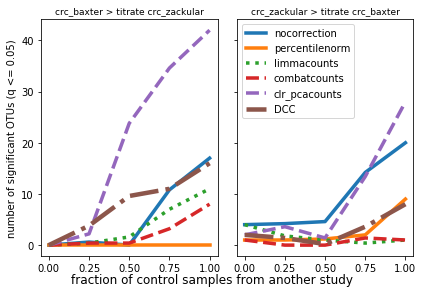

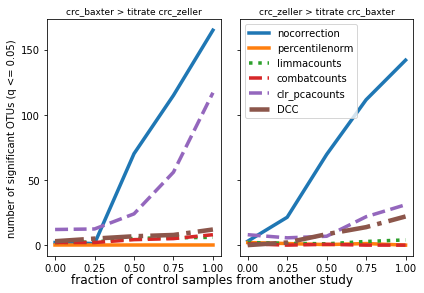

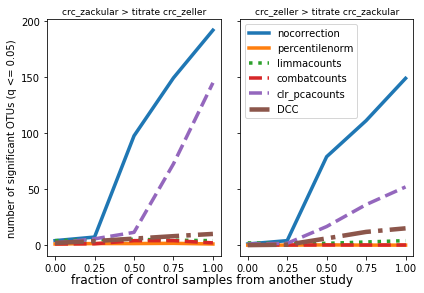

In [8]:
num_replicates= 5

fractions = [0,.25 , .50, 0.75, 1] # fraction of controls replaced
corrections = ["nocorrection","percentilenorm","limmacounts","combatcounts","clr_pcacounts","DCC"] 
corrections_copy = corrections


for s in range(len(all_studies)):
    for s2 in range((s+1),len(all_studies)):
        d11 = all_studies[s] # 'HanniganGD_2017'
        d21 = all_studies[s2] #'YuJ_2015'
        d12 = all_studies[s2] #'YuJ_2015'
        d22 = all_studies[s] #'HanniganGD_2017'

        
        titrate1,biomarkers1 = titration(d1 = d11, d2 = d21, 
                                   metadata_table = metadata_table,fractions = fractions,corrections = corrections)
        
        biomarker_list_list = []
        for i in range(num_replicates):
            biomarker_list_list.append(biomarkers1["clr_pcacounts"][i][0])

        agreement_onedataset = list(reduce(set.intersection, [set(item) for item in biomarker_list_list ]))
        df_biomarkers.loc[agreement_onedataset,d11] = 1
        
        df_biomarkers.to_csv( "DF_biomarkers.csv",index=True)

        titrate2,biomarkers2 = titration(d1 = d12 , d2 = d22, 
                                   metadata_table = metadata_table,fractions = fractions,corrections = corrections)
        
                #corrections = ["nocorrection","percentilenorm","clr_pcacounts"] 
        corrections = corrections_copy

        import matplotlib.pyplot as plt

        fig, (ax1,ax2) = plt.subplots(1,2,sharex=True, sharey=True)  

        line_widths = [3.5,3.5,3.5,3.5,3.5,4.5]
        line_styles = ['-','-',":","--","--",'-.']

        for c in range(len(corrections)):
            ax1.plot(titrate1[corrections[c]]["fraction"],titrate1[corrections[c]]["num_sig"],
                     label = corrections[c],linewidth=line_widths[c],linestyle = line_styles[c])
        d1 = d11
        d2 = d21
        ax1.set_title(d1 + ' > titrate ' + d2 ,fontsize=9)

        for c in range(len(corrections)):
            ax2.plot(titrate2[corrections[c]]["fraction"],titrate2[corrections[c]]["num_sig"],
                     label = corrections[c],linewidth=line_widths[c],linestyle = line_styles[c])

        d2 = d22
        d1 = d12 
        ax2.set_title(d1 + ' > titrate ' + d2 ,fontsize=9)

        ax1.locator_params(nbins=5, axis='y')
        ax2.legend(loc=2,prop={'size':10})
        #fig.text(0.001, 0.5, 'number of significant OTUs (q <= 0.05)', va='center', rotation='vertical',fontsize=12)
        fig.text(0.5, 0.003, 'fraction of control samples from another study', ha='center',fontsize=12)
        ax1.set_ylabel('number of significant OTUs (q <= 0.05)')
        plt.tight_layout()
        #plt.show()
        
        plt.savefig(out_dir  + 'titrate_' + d11 + '_' + d21 + '.pdf',dpi=300,format='pdf')

In [9]:
print(all_studies)
for s in range(len(all_studies)):
    for s2 in range((s+1),len(all_studies)):
        print(all_studies[s] + " " + all_studies[s2])
        print(all_studies[s2] + " " + all_studies[s])

['crc_baxter', 'crc_zackular', 'crc_zeller']
crc_baxter crc_zackular
crc_zackular crc_baxter
crc_baxter crc_zeller
crc_zeller crc_baxter
crc_zackular crc_zeller
crc_zeller crc_zackular


In [10]:
#correction = "clr_scale_pca"
#feature_table = pd.read_csv(data_dir  +"feature_table_" + trans + "_" + correction + ".txt" ,delimiter = "\t",header=0)


In [11]:
#(feature_table > 1e-4).iloc[50,:].astype(bool).sum()/feature_table.shape[1]

#feature_table_titrate_control.iloc[tax,:].astype(bool).sum()

In [12]:
#(feature_table.iloc[50,:].astype(bool).sum()/feature_table.shape[1])

In [13]:
corrections

['nocorrection',
 'percentilenorm',
 'limmacounts',
 'combatcounts',
 'clr_pcacounts',
 'DCC']

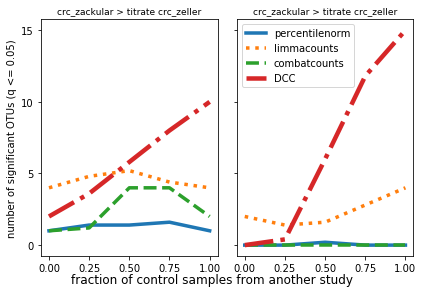

In [19]:
 corrections = ["nocorrection","percentilenorm","limmacounts","combatcounts","clr_pcacounts","DCC"] 

 


fig, (ax1,ax2) = plt.subplots(1,2,sharex=True, sharey=True)  

line_widths = [3.5,3.5,3.5,3.5,3.5,4.5]
line_styles = ['-','-',":","--","--",'-.']

for c in [1,2,3,5]:# range(len(corrections)): # [1,2,3,5]:#
    ax1.plot(titrate1[corrections[c]]["fraction"],titrate1[corrections[c]]["num_sig"],
             label = corrections[c],linewidth=line_widths[c],linestyle = line_styles[c])
d1 = all_studies[1]
d2 = all_studies[2]
ax1.set_title(d1 + ' > titrate ' + d2 ,fontsize=9)

for c in [1,2,3,5]:
    ax2.plot(titrate2[corrections[c]]["fraction"],titrate2[corrections[c]]["num_sig"],
             label = corrections[c],linewidth=line_widths[c],linestyle = line_styles[c])

d2 = all_studies[2]
d1 = all_studies[1] 
ax2.set_title(d1 + ' > titrate ' + d2 ,fontsize=9)

ax1.locator_params(nbins=5, axis='y')
ax2.legend(loc=2,prop={'size':10})
#fig.text(0.001, 0.5, 'number of significant OTUs (q <= 0.05)', va='center', rotation='vertical',fontsize=12)
fig.text(0.5, 0.003, 'fraction of control samples from another study', ha='center',fontsize=12)
ax1.set_ylabel('number of significant OTUs (q <= 0.05)')
plt.tight_layout()
#plt.show()

plt.savefig(out_dir  + 'titrate_' + d11 + '_' + d21 + '.pdf',dpi=300,format='pdf')